In [1]:
!pip install efficient-apriori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from efficient_apriori import apriori
import warnings
warnings.filterwarnings('ignore')

## 0. Data Info

1. Title: "Anonymous web data from www.microsoft.com"

2. Source Information

   -- Creators: Jack S. Breese, David Heckerman, Carl M. Kadie

        -- Microsoft Research, Redmond WA, 98052-6399, USA
     
        -- breese@microsoft.com, heckerma@microsoft.com, carlk@microsoft.com

   -- Donor: Breese, Heckerman, & Kadie

   -- Date: November 1998
 
3. Past Usage:

   -- J. Breese, D. Heckerman., C. Kadie _Empirical 
      Analysis of Predictive Algorithms for Collaborative Filtering_ Proceedings of the Fourteenth Conference on Uncertainty in Artificial Intelligence,
      Madison, WI, July, 1998. Also, expanded as Microsoft Research Technical Report MSR-TR-98-12,
      
      The papers are available on-line at:

        http://research.microsoft.com/users/breese/cfalgs.html

      -- Results: Used to compare various memory-based and model-based collobative filtering.

    - Predicted attribute: Goal was to predict what areas of the web site a user visited based on data on what other areas he or she visited.

4. Relevant Information:

    We created the data by sampling and processing the www.microsoft.com logs. The data records the use of www.microsoft.com by 38000 anonymous, randomly-selected users. For each user, the data lists all the areas of
    the web site (Vroots) that user visited in a one week timeframe.

    Users are identified only by a sequential number, for example, User #14988, User #14989, etc. The file contains no personally identifiable information. The 294 Vroots are identified by their title (e.g. "NetShow for PowerPoint") and URL (e.g. "/stream"). The data comes from one week in February, 1998.

    Dataset format:

	-- The data is in an ASCII-based sparse-data format called "DST".

           Each line of the data file starts with a letter which tells the line's type. The three line types of interest are:

               -- Attribute lines:

		          For example, 'A,1277,1,"NetShow for PowerPoint","/stream"'

                  Where:
                        'A' marks this as an attribute line,
                        '1277' is the attribute ID number for an area of the website
                                 (called a Vroot),
	                    '1' may be ignored,
			
                        '"NetShow for PowerPoint"' is the title of the Vroot,

                        '"/stream"' is the URL relative to "http://www.microsoft.com"

               -- Case and Vote Lines:

                  For each user, there is a case line followed by zero or more vote lines.

                  For example:
                        C,10164,"10164"
                        V,1123,1
                        V,1009,1
                        V,1052,1
                  Where:
                        'C' marks this as a case line,
                        '10164' is the case ID number of a user,
                        'V' marks the vote lines for this case,
                        '1123', 1009', 1052' are the attributes ID's of Vroots that a user visited.
                        '1' may be ignored.

5. Number of Instances:

      -- Training: 32711

      -- Testing:   5000

    Each instance represents an anonymous, randomly selected user of the web site.

6. Number of Attributes: 294

7. Attribute Information:

   Each attribute is an area ("vroot") of the www.microsoft.com web site.

   The datasets record which Vroots each user visited in a one-week timeframe in Feburary 1998.

8. Missing Attribute Values: 

   The data is very sparse, so vroot visits are explicit nonvisits are implicit (missing).

9. Class Distribution: 

    Mean number of vroot visits per case: 3.0

## 1. Data Preprocessing

In [3]:
raw_web_data = pd.read_csv('/content/drive/MyDrive/anonymous-msweb-data.csv', header=None)
raw_web_data.rename(columns={0: 'Label'}, inplace=True)
raw_web_data.head(10)

,Label,1,2,3,4,5
0,I,4,www.microsoft.com,created by getlog.pl,NaN,NaN
1,T,1,VRoot,0,0,VRoot
2,N,0,0,NaN,NaN,NaN
3,N,1,1,NaN,NaN,NaN
4,T,2,Hide1,0,0,Hide
5,N,0,0,NaN,NaN,NaN
6,N,1,1,NaN,NaN,NaN
7,A,1287,1,International AutoRoute,/autoroute,NaN
8,A,1288,1,library,/library,NaN
9,A,1289,1,Master Chef Product Information,/masterchef,NaN


### 1.1 Attribute Lines

In [4]:
attribute = raw_web_data[raw_web_data['Label'] == 'A'].reset_index(drop=True)
attribute.columns = ['label', 'Attribute_ID', 'ignore', 'Vroot_Title', 'subURL', 'del']
attribute = attribute.drop(columns=['label', 'ignore', 'del'])
attribute['URL'] = 'http://www.microsoft.com'
for i in range(len(attribute)):
    attribute['URL'][i] = 'http://www.microsoft.com' + attribute['subURL'][i]
print('There are {} Attribute IDs in all.'.format(len(attribute)))
attribute.head()

There are 294 Attribute IDs in all.


,Attribute_ID,Vroot_Title,subURL,URL
0,1287,International AutoRoute,/autoroute,http://www.microsoft.com/autoroute
1,1288,library,/library,http://www.microsoft.com/library
2,1289,Master Chef Product Information,/masterchef,http://www.microsoft.com/masterchef
3,1297,Central America,/centroam,http://www.microsoft.com/centroam
4,1215,For Developers Only Info,/developer,http://www.microsoft.com/developer


### 1.2 Vote Lines

In [5]:
Case_Vote = raw_web_data.query('Label in ["C", "V"]').reset_index(drop=True)
Case_Vote.head(5)

,Label,1,2,3,4,5
0,C,10001,10001,NaN,NaN,NaN
1,V,1000,1,NaN,NaN,NaN
2,V,1001,1,NaN,NaN,NaN
3,V,1002,1,NaN,NaN,NaN
4,C,10002,10002,NaN,NaN,NaN


In [6]:
for i in range(len(Case_Vote)):
    if Case_Vote['Label'][i] == 'C':
        temp_Case_ID = Case_Vote[1][i]
        continue
    Case_Vote[2][i] = temp_Case_ID
Case_Vote.head(10)

,Label,1,2,3,4,5
0,C,10001,10001,NaN,NaN,NaN
1,V,1000,10001,NaN,NaN,NaN
2,V,1001,10001,NaN,NaN,NaN
3,V,1002,10001,NaN,NaN,NaN
4,C,10002,10002,NaN,NaN,NaN
5,V,1001,10002,NaN,NaN,NaN
6,V,1003,10002,NaN,NaN,NaN
7,C,10003,10003,NaN,NaN,NaN
8,V,1001,10003,NaN,NaN,NaN
9,V,1003,10003,NaN,NaN,NaN


In [7]:
Vote = Case_Vote[Case_Vote['Label'] == 'V'].reset_index(drop=True)
Vote.columns = ['Label', 'Vroot_ID', 'Case_ID', 'Attribute_ID', 'Vroot_Title', 'subURL']
Vote['URL'] = 'http://www.microsoft.com'
for i in range(len(Vote)):
    Vroot_ID_i = Vote['Vroot_ID'][i]
    for j in range(len(attribute)):
        if attribute['Attribute_ID'][j] == Vroot_ID_i:
            Vote['Attribute_ID'][i] = attribute['Attribute_ID'][j]
            Vote['Vroot_Title'][i] = attribute['Vroot_Title'][j]
            Vote['subURL'][i] = attribute['subURL'][j]
            Vote['URL'][i] = attribute['URL'][j]
Vote

,Label,Vroot_ID,Case_ID,Attribute_ID,Vroot_Title,subURL,URL
0,V,1000,10001,1000,regwiz,/regwiz,http://www.microsoft.com/regwiz
1,V,1001,10001,1001,Support Desktop,/support,http://www.microsoft.com/support
2,V,1002,10001,1002,End User Produced View,/athome,http://www.microsoft.com/athome
3,V,1001,10002,1001,Support Desktop,/support,http://www.microsoft.com/support
4,V,1003,10002,1003,Knowledge Base,/kb,http://www.microsoft.com/kb
...,...,...,...,...,...,...,...
98649,V,1003,42709,1003,Knowledge Base,/kb,http://www.microsoft.com/kb
98650,V,1035,42710,1035,Windows95 Support,/windowssupport,http://www.microsoft.com/windowssupport
98651,V,1001,42710,1001,Support Desktop,/support,http://www.microsoft.com/support
98652,V,1018,42710,1018,isapi,/isapi,http://www.microsoft.com/isapi


## 2. Data Details

`Label`: V, meaning that these are all Vote lines

`Vroot_ID`: attribute ID of Vroots that a user visited

`Case_ID`: case ID number of a user

`Attribute_ID`: same as to `Vroot_ID`

`Vroot_Title`: the title of the Vroot

`subURL`: the URL relative to 'http://www.microsoft.com', eg. '/stream'

`URL`: the complete URL, eg. 'http://www.microsoft.com/stream'

### 2.1 *Frequency and Histogram* -- `Vroot_Title`, `URL`

In [8]:
Vote['Vroot_Title'].value_counts()[0:20]

Free Downloads                               10836
Internet Explorer                             9383
Microsoft.com Search                          8463
isapi                                         5330
Products                                      5108
Windows Family of OSs                         4628
Support Desktop                               4451
Internet Site Construction for Developers     3220
Knowledge Base                                2968
Web Site Builder's Gallery                    2123
Windows95 Support                             1791
MS Office Info                                1506
Developer Workshop                            1500
Games                                         1446
Windows 95                                    1160
Windows NT Server                             1115
SiteBuilder Network Membership                1110
Developer Network                             1087
regwiz                                         912
International IE content       

In [9]:
Vroot_Title_Counts = pd.DataFrame(Vote['Vroot_Title'].value_counts()).sort_values(by='Vroot_Title', ascending=True).rename(columns={'Vroot_Title': 'Vroot_Title_Count'})
Vroot_Title_Counts

,Vroot_Title_Count
partner,1
Professional Developer Conference,1
security.,1
Multimedia Golf,1
NetShow for PowerPoint,1
...,...
Products,5108
isapi,5330
Microsoft.com Search,8463
Internet Explorer,9383


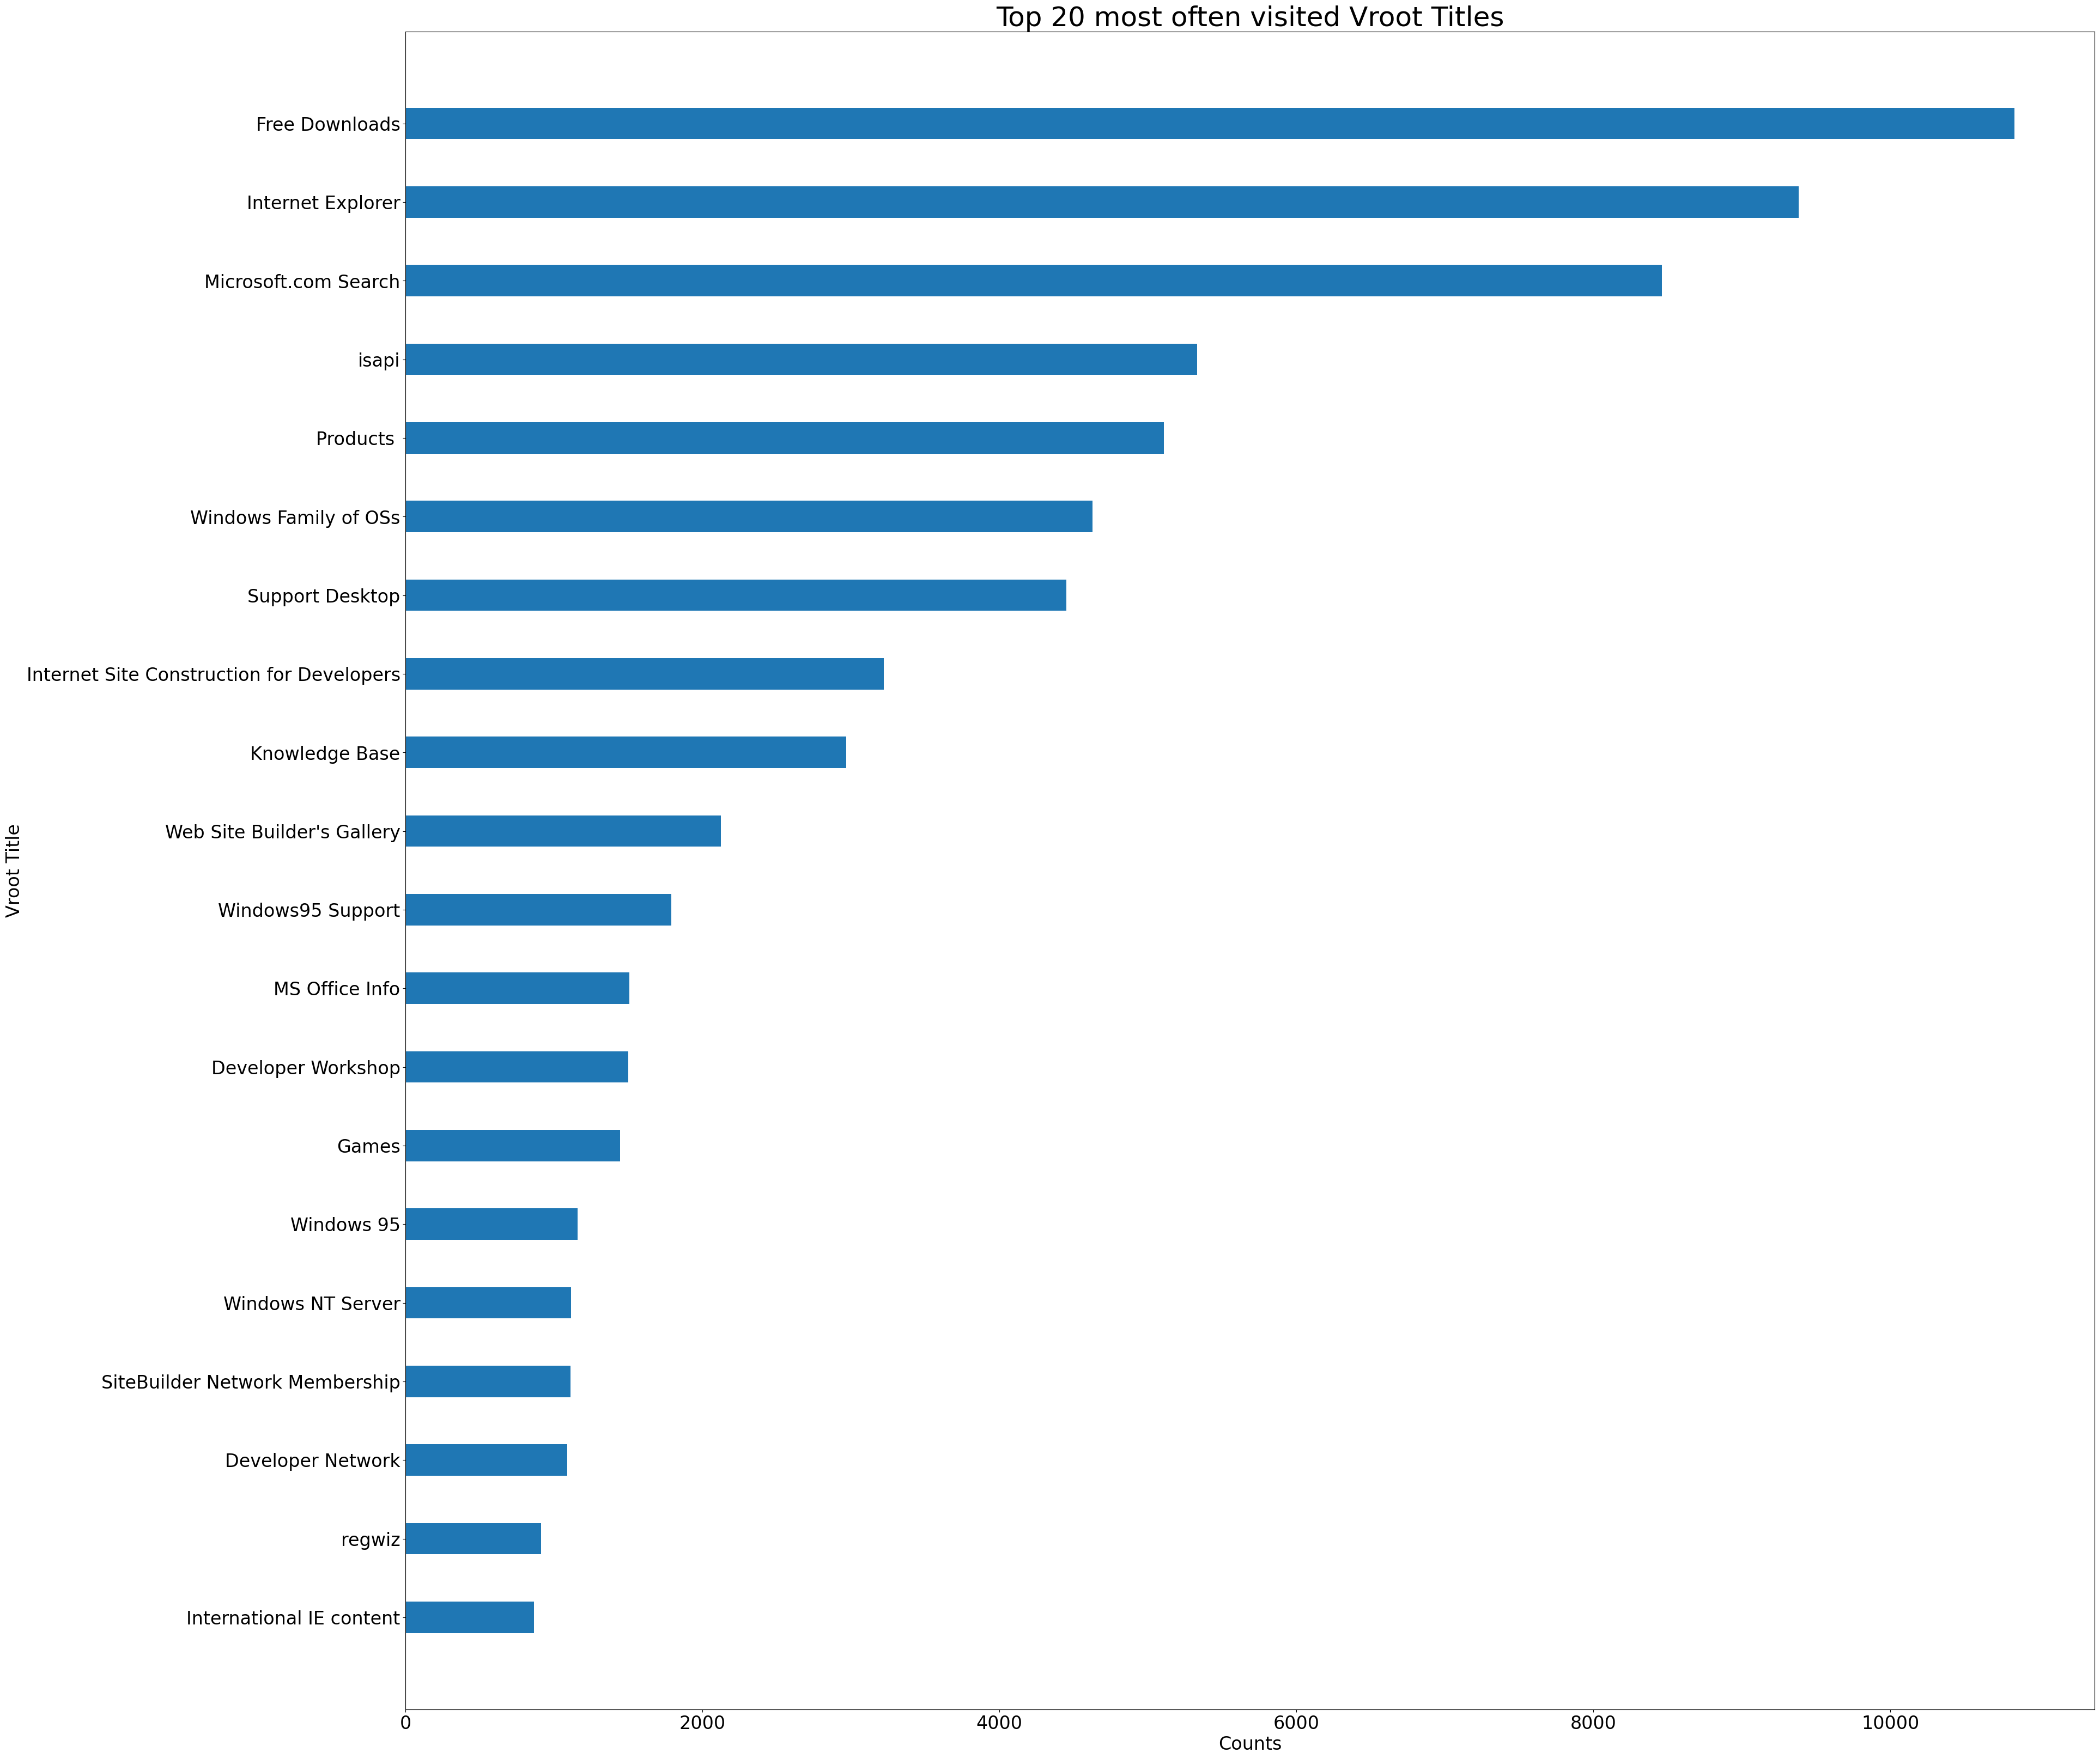

In [10]:
plt.figure(figsize=(40, 40))
plt.yticks(list(range(20)), list(Vroot_Title_Counts.tail(20).index), fontsize=24)
plt.xticks(fontsize=24)
plt.barh(Vroot_Title_Counts.tail(20).index, width=Vroot_Title_Counts['Vroot_Title_Count'].tail(20), height=0.4)
plt.ylabel('Vroot Title', fontsize=24)
plt.xlabel('Counts', fontsize=24)
plt.title('Top 20 most often visited Vroot Titles', fontsize=36, loc='center')
plt.show()

In [11]:
Vote['URL'].value_counts()[0:20]

http://www.microsoft.com/msdownload        10836
http://www.microsoft.com/ie                 9383
http://www.microsoft.com/search             8463
http://www.microsoft.com/isapi              5330
http://www.microsoft.com/products           5108
http://www.microsoft.com/windows            4628
http://www.microsoft.com/support            4451
http://www.microsoft.com/sitebuilder        3220
http://www.microsoft.com/kb                 2968
http://www.microsoft.com/gallery            2123
http://www.microsoft.com/windowssupport     1791
http://www.microsoft.com/office             1506
http://www.microsoft.com/workshop           1500
http://www.microsoft.com/games              1446
http://www.microsoft.com/windows95          1160
http://www.microsoft.com/ntserver           1115
http://www.microsoft.com/sbnmember          1110
http://www.microsoft.com/msdn               1087
http://www.microsoft.com/regwiz              912
http://www.microsoft.com/ie_intl             865
Name: URL, dtype: in

In [12]:
URL_Counts = pd.DataFrame(Vote['URL'].value_counts()).sort_values(by='URL', ascending=True).rename(columns={'URL': 'URL_Count'})
URL_Counts

,URL_Count
http://www.microsoft.com/partner,1
http://www.microsoft.com/pdc,1
http://www.microsoft.com/security.,1
http://www.microsoft.com/msgolf,1
http://www.microsoft.com/stream,1
...,...
http://www.microsoft.com/products,5108
http://www.microsoft.com/isapi,5330
http://www.microsoft.com/search,8463
http://www.microsoft.com/ie,9383


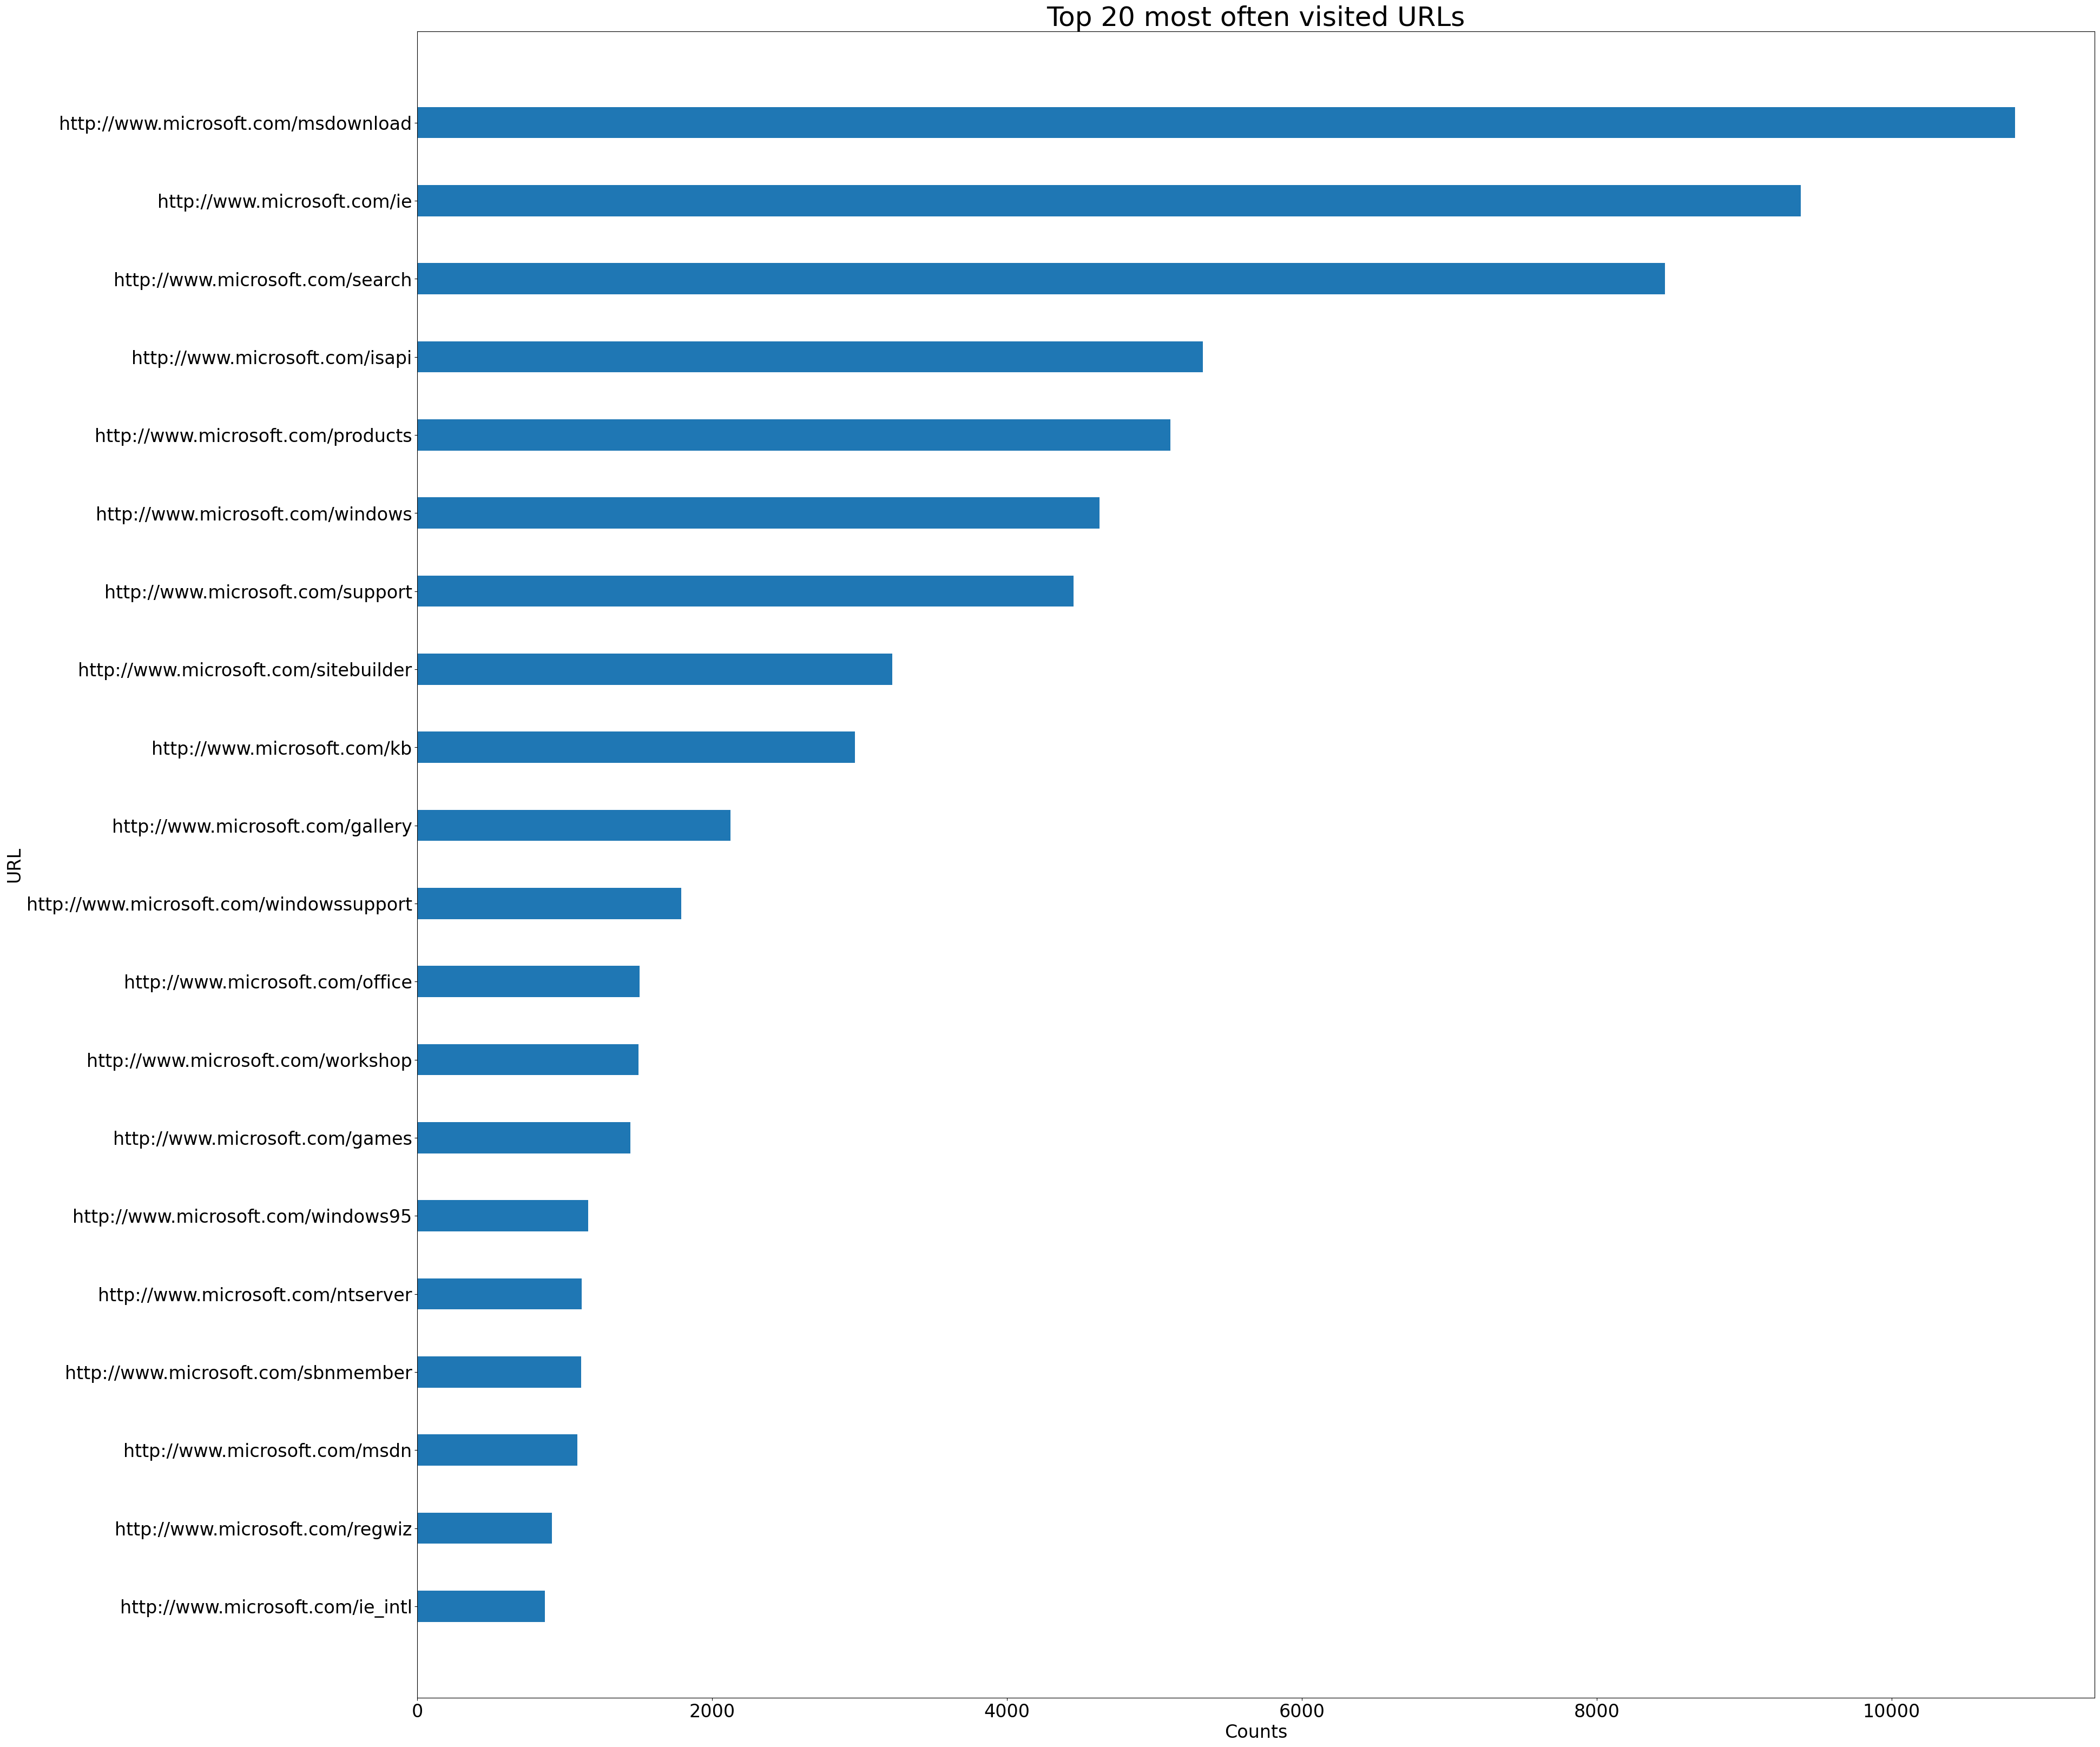

In [13]:
plt.figure(figsize=(40, 40))
plt.yticks(list(range(20)), list(URL_Counts.tail(20).index), fontsize=24)
plt.xticks(fontsize=24)
plt.barh(URL_Counts.tail(20).index, width=URL_Counts['URL_Count'].tail(20), height=0.4)
plt.ylabel('URL', fontsize=24)
plt.xlabel('Counts', fontsize=24)
plt.title('Top 20 most often visited URLs', fontsize=36, loc='center')
plt.show()

### 2.2 *Box Plot*

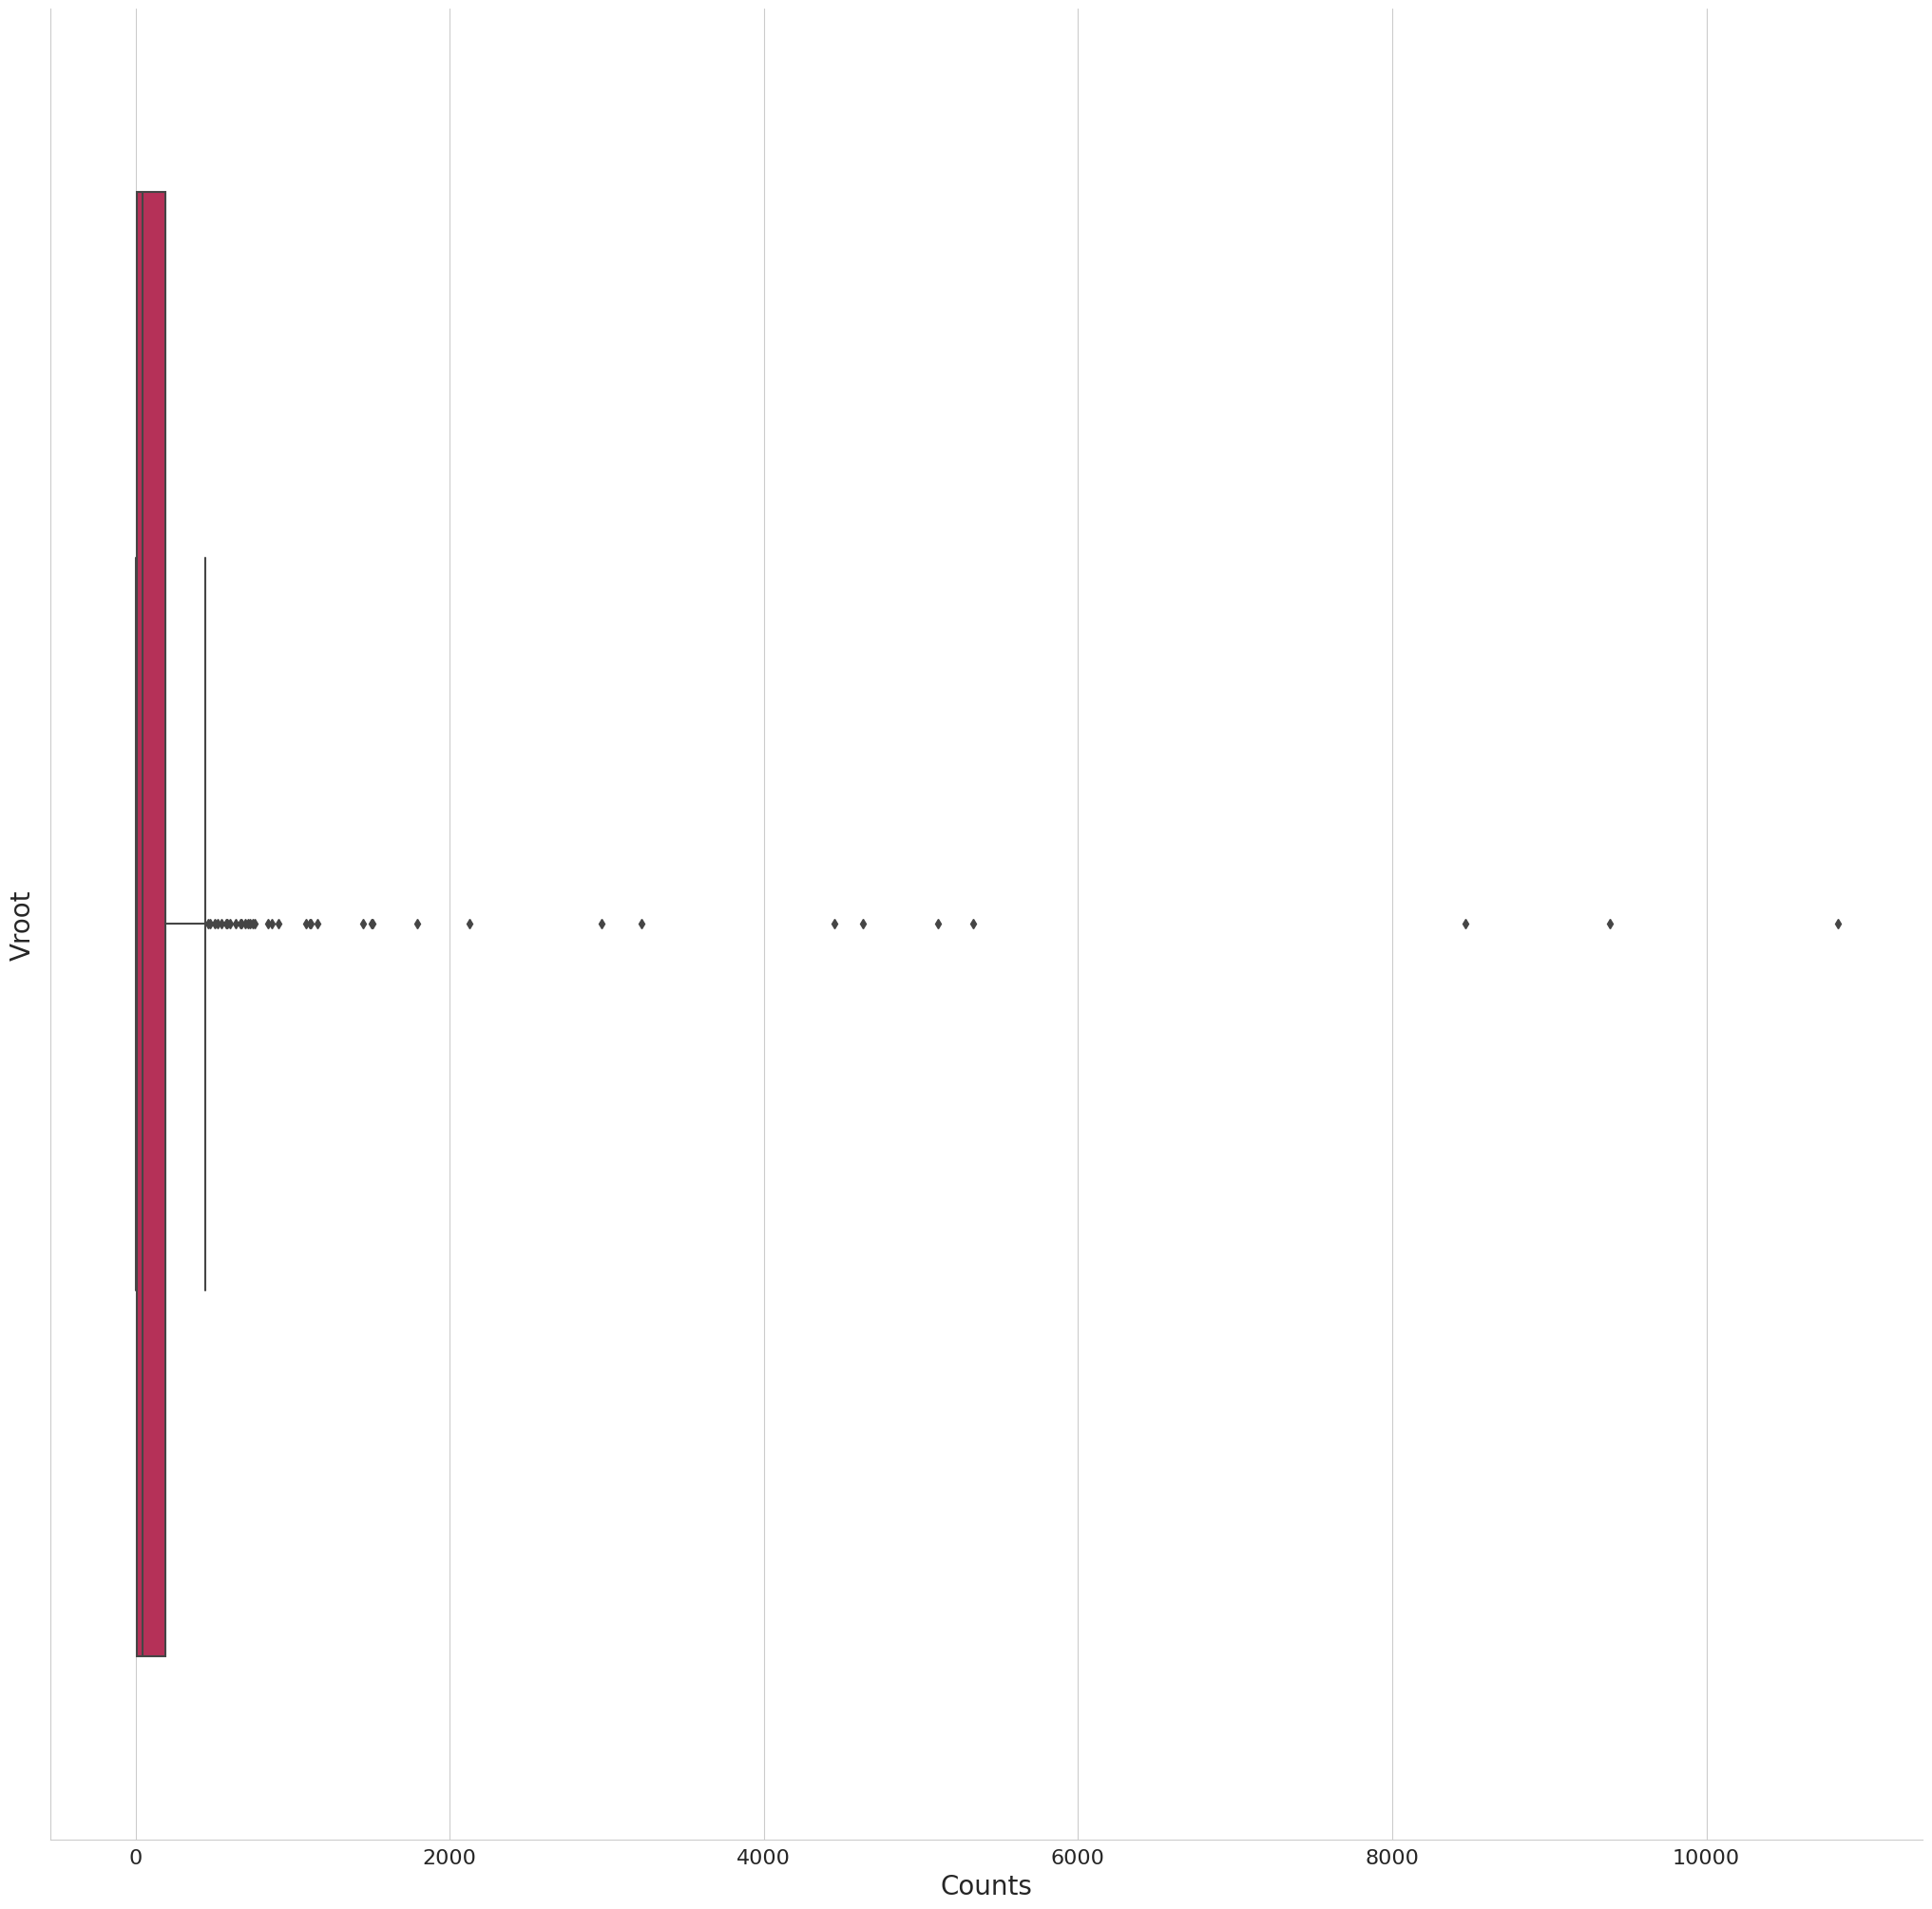

In [14]:
sns.set_style("whitegrid")
operations_count_box = sns.catplot(data=Vroot_Title_Counts, kind='box', x='Vroot_Title_Count', height=20, palette='rocket')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Vroot', fontsize=20)
plt.xlabel('Counts', fontsize=20)
plt.show()

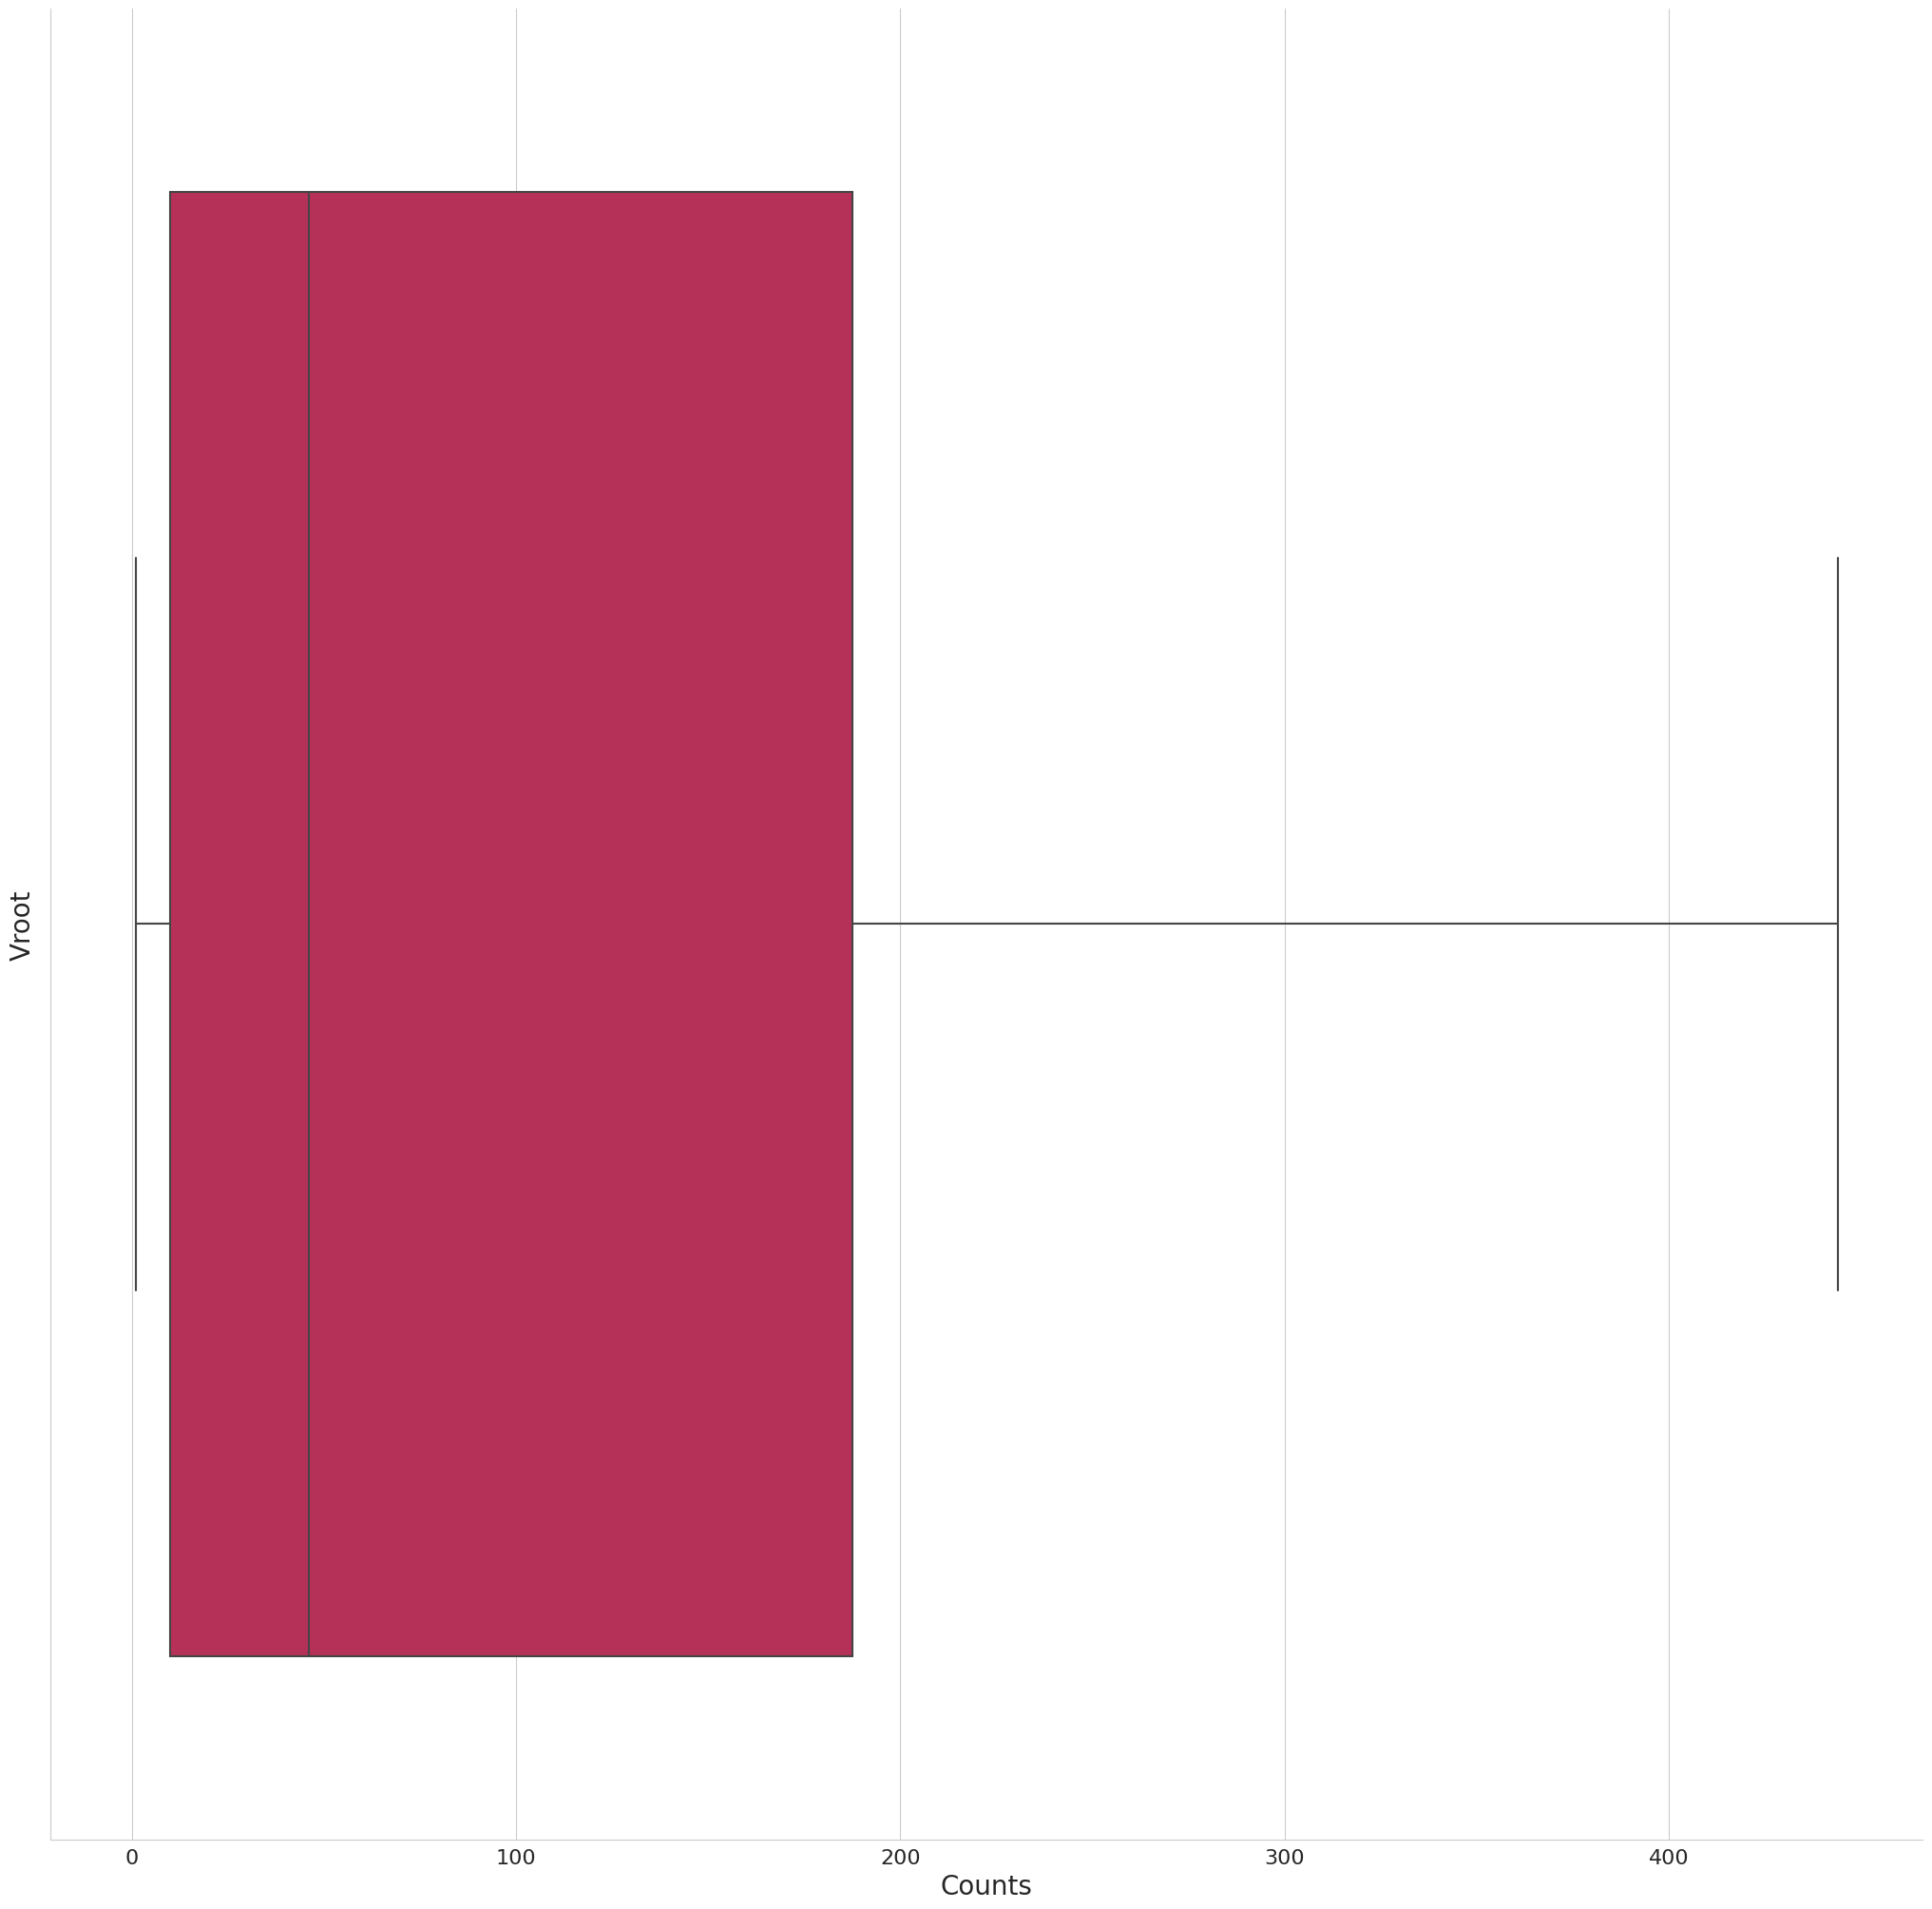

In [15]:
sns.set_style("whitegrid")
# No outliers
operations_count_box_no_outliers = sns.catplot(data=Vroot_Title_Counts, kind='box', x='Vroot_Title_Count', height=20, palette='rocket', sym='')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Vroot', fontsize=20)
plt.xlabel('Counts', fontsize=20)
plt.show()

### 2.3 *Five Number Summary*

In [16]:
pd.DataFrame(Vroot_Title_Counts['Vroot_Title_Count'].describe().loc[['max', '75%', '50%', '25%', 'min']])

,Vroot_Title_Count
max,10836.0
75%,187.5
50%,46.0
25%,10.0
min,1.0


## 3. Association Pattern Mining

### 3.1 Construct the Itemsets

In [17]:
transaction_df = pd.DataFrame(columns=['TID', 'Vroot_ID', 'Vroot_Title', 'URL'])
TID_set = list(Vote['Case_ID'].unique())
transaction_df['TID'] = TID_set
transaction_df

,TID,Vroot_ID,Vroot_Title,URL
0,10001,NaN,NaN,NaN
1,10002,NaN,NaN,NaN
2,10003,NaN,NaN,NaN
3,10004,NaN,NaN,NaN
4,10005,NaN,NaN,NaN
...,...,...,...,...
32706,42707,NaN,NaN,NaN
32707,42708,NaN,NaN,NaN
32708,42709,NaN,NaN,NaN
32709,42710,NaN,NaN,NaN


In [18]:
for i in range(len(transaction_df)):
    tid = transaction_df['TID'][i]
    transaction_df['Vroot_ID'][i] = tuple(Vote[Vote['Case_ID'] == tid]['Vroot_ID'])
    transaction_df['Vroot_Title'][i] = tuple(Vote[Vote['Case_ID'] == tid]['Vroot_Title'])
    transaction_df['URL'][i] = tuple(Vote[Vote['Case_ID'] == tid]['URL'])
transaction_df

,TID,Vroot_ID,Vroot_Title,URL
0,10001,"(1000, 1001, 1002)","(regwiz, Support Desktop, End User Produced View)","(http://www.microsoft.com/regwiz, http://www.m..."
1,10002,"(1001, 1003)","(Support Desktop, Knowledge Base)","(http://www.microsoft.com/support, http://www...."
2,10003,"(1001, 1003, 1004)","(Support Desktop, Knowledge Base, Microsoft.co...","(http://www.microsoft.com/support, http://www...."
3,10004,"(1005,)","(Norway,)","(http://www.microsoft.com/norge,)"
4,10005,"(1006,)","(misc,)","(http://www.microsoft.com/misc,)"
...,...,...,...,...
32706,42707,"(1008, 1030, 1009, 1058, 1004, 1018)","(Free Downloads, Windows NT Server, Windows Fa...","(http://www.microsoft.com/msdownload, http://w..."
32707,42708,"(1008, 1027, 1123, 1038, 1026, 1041)","(Free Downloads, Internet Development, Germany...","(http://www.microsoft.com/msdownload, http://w..."
32708,42709,"(1001, 1003)","(Support Desktop, Knowledge Base)","(http://www.microsoft.com/support, http://www...."
32709,42710,"(1035, 1001, 1018)","(Windows95 Support, Support Desktop, isapi)","(http://www.microsoft.com/windowssupport, http..."


In [19]:
transaction_df.to_csv('web_browsing_transaction.csv')

In [20]:
print('There are {} TIDs.'.format(len(transaction_df)))

There are 32711 TIDs.


### 3.2 Apriori

In [21]:
transactions = list(transaction_df['Vroot_Title'])

#### 3.2.1 minSupport == 0.1, minConfidence == 0.5

In [22]:
itemsets, rules = apriori(transactions, min_support=0.1, min_confidence=0.5, output_transaction_ids=True)
print(len(itemsets))
print(len(rules))

2
1


In [23]:
[i[0] for i in list(itemsets[1].keys())]

['Support Desktop',
 'Microsoft.com Search',
 'Free Downloads',
 'Windows Family of OSs',
 'Products ',
 'isapi',
 'Internet Explorer']

In [24]:
itemsets_1_URLs = attribute.query('Vroot_Title in ["Support Desktop", "Microsoft.com Search", "Free Downloads", "Windows Family of OSs", "Products ", "isapi", "Internet Explorer"]')['URL']
itemsets_1_URLs = list(itemsets_1_URLs)
itemsets_1_URLs

['http://www.microsoft.com/search',
 'http://www.microsoft.com/msdownload',
 'http://www.microsoft.com/support',
 'http://www.microsoft.com/windows',
 'http://www.microsoft.com/products',
 'http://www.microsoft.com/ie',
 'http://www.microsoft.com/isapi']

In [25]:
itemsets_1_keys = [i for i in list(itemsets[1].keys())]
itemsets_1_counts = [i.itemset_count for i in list(itemsets[1].values())]
itemsets_1 = pd.DataFrame()
itemsets_1['itemset_1_keys'] = itemsets_1_keys
itemsets_1['itemset_1_URLs'] = itemsets_1_URLs
itemsets_1['itemset_1_counts'] = itemsets_1_counts
itemsets_1['itemset_1_supp'] = [i / len(transaction_df) for i in itemsets_1_counts]
itemsets_1 = itemsets_1.sort_values(by='itemset_1_counts', ascending=True).reset_index(drop=True)
itemsets_1

,itemset_1_keys,itemset_1_URLs,itemset_1_counts,itemset_1_supp
0,"(Support Desktop,)",http://www.microsoft.com/search,4451,0.136070
1,"(Windows Family of OSs,)",http://www.microsoft.com/windows,4628,0.141481
2,"(Products ,)",http://www.microsoft.com/products,5108,0.156155
3,"(isapi,)",http://www.microsoft.com/ie,5330,0.162942
4,"(Microsoft.com Search,)",http://www.microsoft.com/msdownload,8463,0.258720
5,"(Internet Explorer,)",http://www.microsoft.com/isapi,9383,0.286845
6,"(Free Downloads,)",http://www.microsoft.com/support,10836,0.331265


In [26]:
[(i[0], i[1]) for i in list(itemsets[2].keys())]

[('Free Downloads', 'Internet Explorer')]

In [27]:
itemsets_2_URLs = attribute.query('Vroot_Title in ["Free Downloads", "Internet Explorer"]')['URL']
itemsets_2_URLs = list(itemsets_2_URLs)
itemsets_2_URLs = (itemsets_2_URLs[0], itemsets_2_URLs[1])
itemsets_2_URLs = [itemsets_2_URLs]
itemsets_2_URLs

[('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/ie')]

In [28]:
itemsets_2_keys = [i for i in list(itemsets[2].keys())]
itemsets_2_counts = [i.itemset_count for i in list(itemsets[2].values())]
itemsets_2 = pd.DataFrame()
itemsets_2['itemset_2_keys'] = itemsets_2_keys
itemsets_2['itemset_2_URLs'] = itemsets_2_URLs
itemsets_2['itemset_2_counts'] = itemsets_2_counts
itemsets_2['itemset_2_supp'] = [i / len(transaction_df) for i in itemsets_2_counts]
itemsets_2 = itemsets_2.sort_values(by='itemset_2_counts', ascending=True).reset_index(drop=True)
itemsets_2

,itemset_2_keys,itemset_2_URLs,itemset_2_counts,itemset_2_supp
0,"(Free Downloads, Internet Explorer)","(http://www.microsoft.com/msdownload, http://w...",5260,0.160802


In [29]:
rules

[{Internet Explorer} -> {Free Downloads}]

#### 3.2.2 minSupport == 0.035, minConfidence == 0.5

In [30]:
itemsets, rules = apriori(transactions, min_support=0.035, min_confidence=0.5, output_transaction_ids=True)
print(len(itemsets))
print(len(rules))

2
6


In [31]:
[i[0] for i in list(itemsets[1].keys())]

['Support Desktop',
 'Knowledge Base',
 'Microsoft.com Search',
 'Free Downloads',
 'Windows Family of OSs',
 'Products ',
 'isapi',
 "Web Site Builder's Gallery",
 'Internet Site Construction for Developers',
 'Games',
 'Internet Explorer',
 'Windows95 Support',
 'Windows 95',
 'MS Office Info',
 'Developer Workshop']

In [32]:
itemsets_1_URLs = []
for k in [i[0] for i in list(itemsets[1].keys())]:
    for j in range(len(attribute)):
        if attribute['Vroot_Title'][j] == k:
            itemsets_1_URLs.append(attribute['URL'][j])
itemsets_1_URLs

['http://www.microsoft.com/support',
 'http://www.microsoft.com/kb',
 'http://www.microsoft.com/search',
 'http://www.microsoft.com/msdownload',
 'http://www.microsoft.com/windows',
 'http://www.microsoft.com/products',
 'http://www.microsoft.com/isapi',
 'http://www.microsoft.com/gallery',
 'http://www.microsoft.com/sitebuilder',
 'http://www.microsoft.com/games',
 'http://www.microsoft.com/ie',
 'http://www.microsoft.com/windowssupport',
 'http://www.microsoft.com/windows95',
 'http://www.microsoft.com/office',
 'http://www.microsoft.com/workshop']

In [33]:
itemsets_1_keys = [i for i in list(itemsets[1].keys())]
itemsets_1_counts = [i.itemset_count for i in list(itemsets[1].values())]
itemsets_1 = pd.DataFrame()
itemsets_1['itemset_1_keys'] = itemsets_1_keys
itemsets_1['itemset_1_URLs'] = itemsets_1_URLs
itemsets_1['itemset_1_counts'] = itemsets_1_counts
itemsets_1['itemset_1_supp'] = [i / len(transaction_df) for i in itemsets_1_counts]
itemsets_1 = itemsets_1.sort_values(by='itemset_1_counts', ascending=True).reset_index(drop=True)
itemsets_1

,itemset_1_keys,itemset_1_URLs,itemset_1_counts,itemset_1_supp
0,"(Windows 95,)",http://www.microsoft.com/windows95,1160,0.035462
1,"(Games,)",http://www.microsoft.com/games,1446,0.044205
2,"(Developer Workshop,)",http://www.microsoft.com/workshop,1500,0.045856
3,"(MS Office Info,)",http://www.microsoft.com/office,1506,0.046040
4,"(Windows95 Support,)",http://www.microsoft.com/windowssupport,1791,0.054752
5,"(Web Site Builder's Gallery,)",http://www.microsoft.com/gallery,2123,0.064902
6,"(Knowledge Base,)",http://www.microsoft.com/kb,2968,0.090734
7,"(Internet Site Construction for Developers,)",http://www.microsoft.com/sitebuilder,3220,0.098438
8,"(Support Desktop,)",http://www.microsoft.com/support,4451,0.136070
9,"(Windows Family of OSs,)",http://www.microsoft.com/windows,4628,0.141481


In [34]:
[(i[0], i[1]) for i in list(itemsets[2].keys())]

[('Free Downloads', 'Internet Explorer'),
 ('Free Downloads', 'Microsoft.com Search'),
 ('Free Downloads', 'Products '),
 ('Free Downloads', 'Support Desktop'),
 ('Free Downloads', 'Windows Family of OSs'),
 ('Free Downloads', 'isapi'),
 ('Internet Explorer', 'Microsoft.com Search'),
 ('Internet Explorer', 'Products '),
 ('Internet Explorer', 'isapi'),
 ('Internet Site Construction for Developers', "Web Site Builder's Gallery"),
 ('Knowledge Base', 'Microsoft.com Search'),
 ('Knowledge Base', 'Support Desktop'),
 ('Knowledge Base', 'isapi'),
 ('Microsoft.com Search', 'Products '),
 ('Microsoft.com Search', 'Support Desktop'),
 ('Microsoft.com Search', 'Windows Family of OSs'),
 ('Microsoft.com Search', 'isapi'),
 ('Products ', 'Windows Family of OSs'),
 ('Products ', 'isapi'),
 ('Support Desktop', 'isapi'),
 ('Windows Family of OSs', 'isapi'),
 ('Windows95 Support', 'isapi')]

In [35]:
itemsets_2_URLs = []
for k in [(i[0], i[1]) for i in list(itemsets[2].keys())]:
    temp = ['', '']
    t = 0
    for j in range(len(attribute)):
        if attribute['Vroot_Title'][j] == k[0]:
            temp[0] = attribute['URL'][j]
        if attribute['Vroot_Title'][j] == k[1]:
            temp[1] = attribute['URL'][j]
        if temp[0] != '' and temp[1] != '' and t == 0:
            t += 1
            itemsets_2_URLs.append(temp)
itemsets_2_URLs = [tuple(i) for i in itemsets_2_URLs]
itemsets_2_URLs

[('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/ie'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/search'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/products'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/support'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/windows'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/isapi'),
 ('http://www.microsoft.com/ie', 'http://www.microsoft.com/search'),
 ('http://www.microsoft.com/ie', 'http://www.microsoft.com/products'),
 ('http://www.microsoft.com/ie', 'http://www.microsoft.com/isapi'),
 ('http://www.microsoft.com/sitebuilder', 'http://www.microsoft.com/gallery'),
 ('http://www.microsoft.com/kb', 'http://www.microsoft.com/search'),
 ('http://www.microsoft.com/kb', 'http://www.microsoft.com/support'),
 ('http://www.microsoft.com/kb', 'http://www.microsoft.com/isapi'),
 ('http://www.microsoft.com/search', 'http://

In [36]:
itemsets_2_keys = [i for i in list(itemsets[2].keys())]
itemsets_2_counts = [i.itemset_count for i in list(itemsets[2].values())]
itemsets_2 = pd.DataFrame()
itemsets_2['itemset_2_keys'] = itemsets_2_keys
itemsets_2['itemset_2_URLs'] = itemsets_2_URLs
itemsets_2['itemset_2_counts'] = itemsets_2_counts
itemsets_2['itemset_2_supp'] = [i / len(transaction_df) for i in itemsets_2_counts]
itemsets_2 = itemsets_2.sort_values(by='itemset_2_counts', ascending=True).reset_index(drop=True)
itemsets_2

,itemset_2_keys,itemset_2_URLs,itemset_2_counts,itemset_2_supp
0,"(Internet Site Construction for Developers, We...","(http://www.microsoft.com/sitebuilder, http://...",1155,0.035309
1,"(Free Downloads, Support Desktop)","(http://www.microsoft.com/msdownload, http://w...",1191,0.036410
2,"(Products , isapi)","(http://www.microsoft.com/products, http://www...",1205,0.036838
3,"(Products , Windows Family of OSs)","(http://www.microsoft.com/products, http://www...",1271,0.038855
4,"(Knowledge Base, Microsoft.com Search)","(http://www.microsoft.com/kb, http://www.micro...",1281,0.039161
5,"(Microsoft.com Search, Windows Family of OSs)","(http://www.microsoft.com/search, http://www.m...",1283,0.039222
6,"(Internet Explorer, isapi)","(http://www.microsoft.com/ie, http://www.micro...",1406,0.042982
7,"(Microsoft.com Search, isapi)","(http://www.microsoft.com/search, http://www.m...",1465,0.044786
8,"(Windows Family of OSs, isapi)","(http://www.microsoft.com/windows, http://www....",1472,0.045000
9,"(Windows95 Support, isapi)","(http://www.microsoft.com/windowssupport, http...",1507,0.046070


In [37]:
rules

[{Internet Explorer} -> {Free Downloads},
 {Windows Family of OSs} -> {Free Downloads},
 {Web Site Builder's Gallery} -> {Internet Site Construction for Developers},
 {Knowledge Base} -> {Support Desktop},
 {Knowledge Base} -> {isapi},
 {Windows95 Support} -> {isapi}]

#### 3.2.3 minSupport == 0.1, minConfidence == 0.1

In [38]:
itemsets, rules = apriori(transactions, min_support=0.1, min_confidence=0.1, output_transaction_ids=True)
print(len(itemsets))
print(len(rules))

2
2


In [39]:
[i[0] for i in list(itemsets[1].keys())]

['Support Desktop',
 'Microsoft.com Search',
 'Free Downloads',
 'Windows Family of OSs',
 'Products ',
 'isapi',
 'Internet Explorer']

In [40]:
itemsets_1_URLs = []
for k in [i[0] for i in list(itemsets[1].keys())]:
    for j in range(len(attribute)):
        if attribute['Vroot_Title'][j] == k:
            itemsets_1_URLs.append(attribute['URL'][j])
itemsets_1_URLs

['http://www.microsoft.com/support',
 'http://www.microsoft.com/search',
 'http://www.microsoft.com/msdownload',
 'http://www.microsoft.com/windows',
 'http://www.microsoft.com/products',
 'http://www.microsoft.com/isapi',
 'http://www.microsoft.com/ie']

In [41]:
itemsets_1_keys = [i for i in list(itemsets[1].keys())]
itemsets_1_counts = [i.itemset_count for i in list(itemsets[1].values())]
itemsets_1 = pd.DataFrame()
itemsets_1['itemset_1_keys'] = itemsets_1_keys
itemsets_1['itemset_1_URLs'] = itemsets_1_URLs
itemsets_1['itemset_1_counts'] = itemsets_1_counts
itemsets_1['itemset_1_supp'] = [i / len(transaction_df) for i in itemsets_1_counts]
itemsets_1 = itemsets_1.sort_values(by='itemset_1_counts', ascending=True).reset_index(drop=True)
itemsets_1

,itemset_1_keys,itemset_1_URLs,itemset_1_counts,itemset_1_supp
0,"(Support Desktop,)",http://www.microsoft.com/support,4451,0.136070
1,"(Windows Family of OSs,)",http://www.microsoft.com/windows,4628,0.141481
2,"(Products ,)",http://www.microsoft.com/products,5108,0.156155
3,"(isapi,)",http://www.microsoft.com/isapi,5330,0.162942
4,"(Microsoft.com Search,)",http://www.microsoft.com/search,8463,0.258720
5,"(Internet Explorer,)",http://www.microsoft.com/ie,9383,0.286845
6,"(Free Downloads,)",http://www.microsoft.com/msdownload,10836,0.331265


In [42]:
[(i[0], i[1]) for i in list(itemsets[2].keys())]

[('Free Downloads', 'Internet Explorer')]

In [43]:
itemsets_2_URLs = []
for k in [(i[0], i[1]) for i in list(itemsets[2].keys())]:
    temp = ['', '']
    t = 0
    for j in range(len(attribute)):
        if attribute['Vroot_Title'][j] == k[0]:
            temp[0] = attribute['URL'][j]
        if attribute['Vroot_Title'][j] == k[1]:
            temp[1] = attribute['URL'][j]
        if temp[0] != '' and temp[1] != '' and t == 0:
            t += 1
            itemsets_2_URLs.append(temp)
itemsets_2_URLs = [tuple(i) for i in itemsets_2_URLs]
itemsets_2_URLs

[('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/ie')]

In [44]:
itemsets_2_keys = [i for i in list(itemsets[2].keys())]
itemsets_2_counts = [i.itemset_count for i in list(itemsets[2].values())]
itemsets_2 = pd.DataFrame()
itemsets_2['itemset_2_keys'] = itemsets_2_keys
itemsets_2['itemset_2_URLs'] = itemsets_2_URLs
itemsets_2['itemset_2_counts'] = itemsets_2_counts
itemsets_2['itemset_2_supp'] = [i / len(transaction_df) for i in itemsets_2_counts]
itemsets_2 = itemsets_2.sort_values(by='itemset_2_counts', ascending=True).reset_index(drop=True)
itemsets_2

,itemset_2_keys,itemset_2_URLs,itemset_2_counts,itemset_2_supp
0,"(Free Downloads, Internet Explorer)","(http://www.microsoft.com/msdownload, http://w...",5260,0.160802


In [45]:
rules

[{Internet Explorer} -> {Free Downloads},
 {Free Downloads} -> {Internet Explorer}]

#### 3.2.4 minSupport == 0.035, minConfidence == 0.1

In [46]:
itemsets, rules = apriori(transactions, min_support=0.035, min_confidence=0.1, output_transaction_ids=True)
print(len(itemsets))
print(len(rules))

2
44


In [47]:
[i[0] for i in list(itemsets[1].keys())]

['Support Desktop',
 'Knowledge Base',
 'Microsoft.com Search',
 'Free Downloads',
 'Windows Family of OSs',
 'Products ',
 'isapi',
 "Web Site Builder's Gallery",
 'Internet Site Construction for Developers',
 'Games',
 'Internet Explorer',
 'Windows95 Support',
 'Windows 95',
 'MS Office Info',
 'Developer Workshop']

In [48]:
itemsets_1_URLs = []
for k in [i[0] for i in list(itemsets[1].keys())]:
    for j in range(len(attribute)):
        if attribute['Vroot_Title'][j] == k:
            itemsets_1_URLs.append(attribute['URL'][j])
itemsets_1_URLs

['http://www.microsoft.com/support',
 'http://www.microsoft.com/kb',
 'http://www.microsoft.com/search',
 'http://www.microsoft.com/msdownload',
 'http://www.microsoft.com/windows',
 'http://www.microsoft.com/products',
 'http://www.microsoft.com/isapi',
 'http://www.microsoft.com/gallery',
 'http://www.microsoft.com/sitebuilder',
 'http://www.microsoft.com/games',
 'http://www.microsoft.com/ie',
 'http://www.microsoft.com/windowssupport',
 'http://www.microsoft.com/windows95',
 'http://www.microsoft.com/office',
 'http://www.microsoft.com/workshop']

In [49]:
itemsets_1_keys = [i for i in list(itemsets[1].keys())]
itemsets_1_counts = [i.itemset_count for i in list(itemsets[1].values())]
itemsets_1 = pd.DataFrame()
itemsets_1['itemset_1_keys'] = itemsets_1_keys
itemsets_1['itemset_1_URLs'] = itemsets_1_URLs
itemsets_1['itemset_1_counts'] = itemsets_1_counts
itemsets_1['itemset_1_supp'] = [i / len(transaction_df) for i in itemsets_1_counts]
itemsets_1 = itemsets_1.sort_values(by='itemset_1_counts', ascending=True).reset_index(drop=True)
itemsets_1

,itemset_1_keys,itemset_1_URLs,itemset_1_counts,itemset_1_supp
0,"(Windows 95,)",http://www.microsoft.com/windows95,1160,0.035462
1,"(Games,)",http://www.microsoft.com/games,1446,0.044205
2,"(Developer Workshop,)",http://www.microsoft.com/workshop,1500,0.045856
3,"(MS Office Info,)",http://www.microsoft.com/office,1506,0.046040
4,"(Windows95 Support,)",http://www.microsoft.com/windowssupport,1791,0.054752
5,"(Web Site Builder's Gallery,)",http://www.microsoft.com/gallery,2123,0.064902
6,"(Knowledge Base,)",http://www.microsoft.com/kb,2968,0.090734
7,"(Internet Site Construction for Developers,)",http://www.microsoft.com/sitebuilder,3220,0.098438
8,"(Support Desktop,)",http://www.microsoft.com/support,4451,0.136070
9,"(Windows Family of OSs,)",http://www.microsoft.com/windows,4628,0.141481


In [50]:
[(i[0], i[1]) for i in list(itemsets[2].keys())]

[('Free Downloads', 'Internet Explorer'),
 ('Free Downloads', 'Microsoft.com Search'),
 ('Free Downloads', 'Products '),
 ('Free Downloads', 'Support Desktop'),
 ('Free Downloads', 'Windows Family of OSs'),
 ('Free Downloads', 'isapi'),
 ('Internet Explorer', 'Microsoft.com Search'),
 ('Internet Explorer', 'Products '),
 ('Internet Explorer', 'isapi'),
 ('Internet Site Construction for Developers', "Web Site Builder's Gallery"),
 ('Knowledge Base', 'Microsoft.com Search'),
 ('Knowledge Base', 'Support Desktop'),
 ('Knowledge Base', 'isapi'),
 ('Microsoft.com Search', 'Products '),
 ('Microsoft.com Search', 'Support Desktop'),
 ('Microsoft.com Search', 'Windows Family of OSs'),
 ('Microsoft.com Search', 'isapi'),
 ('Products ', 'Windows Family of OSs'),
 ('Products ', 'isapi'),
 ('Support Desktop', 'isapi'),
 ('Windows Family of OSs', 'isapi'),
 ('Windows95 Support', 'isapi')]

In [51]:
itemsets_2_URLs = []
for k in [(i[0], i[1]) for i in list(itemsets[2].keys())]:
    temp = ['', '']
    t = 0
    for j in range(len(attribute)):
        if attribute['Vroot_Title'][j] == k[0]:
            temp[0] = attribute['URL'][j]
        if attribute['Vroot_Title'][j] == k[1]:
            temp[1] = attribute['URL'][j]
        if temp[0] != '' and temp[1] != '' and t == 0:
            t += 1
            itemsets_2_URLs.append(temp)
itemsets_2_URLs = [tuple(i) for i in itemsets_2_URLs]
itemsets_2_URLs

[('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/ie'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/search'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/products'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/support'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/windows'),
 ('http://www.microsoft.com/msdownload', 'http://www.microsoft.com/isapi'),
 ('http://www.microsoft.com/ie', 'http://www.microsoft.com/search'),
 ('http://www.microsoft.com/ie', 'http://www.microsoft.com/products'),
 ('http://www.microsoft.com/ie', 'http://www.microsoft.com/isapi'),
 ('http://www.microsoft.com/sitebuilder', 'http://www.microsoft.com/gallery'),
 ('http://www.microsoft.com/kb', 'http://www.microsoft.com/search'),
 ('http://www.microsoft.com/kb', 'http://www.microsoft.com/support'),
 ('http://www.microsoft.com/kb', 'http://www.microsoft.com/isapi'),
 ('http://www.microsoft.com/search', 'http://

In [52]:
itemsets_2_keys = [i for i in list(itemsets[2].keys())]
itemsets_2_counts = [i.itemset_count for i in list(itemsets[2].values())]
itemsets_2 = pd.DataFrame()
itemsets_2['itemset_2_keys'] = itemsets_2_keys
itemsets_2['itemset_2_URLs'] = itemsets_2_URLs
itemsets_2['itemset_2_counts'] = itemsets_2_counts
itemsets_2['itemset_2_supp'] = [i / len(transaction_df) for i in itemsets_2_counts]
itemsets_2 = itemsets_2.sort_values(by='itemset_2_counts', ascending=True).reset_index(drop=True)
itemsets_2

,itemset_2_keys,itemset_2_URLs,itemset_2_counts,itemset_2_supp
0,"(Internet Site Construction for Developers, We...","(http://www.microsoft.com/sitebuilder, http://...",1155,0.035309
1,"(Free Downloads, Support Desktop)","(http://www.microsoft.com/msdownload, http://w...",1191,0.036410
2,"(Products , isapi)","(http://www.microsoft.com/products, http://www...",1205,0.036838
3,"(Products , Windows Family of OSs)","(http://www.microsoft.com/products, http://www...",1271,0.038855
4,"(Knowledge Base, Microsoft.com Search)","(http://www.microsoft.com/kb, http://www.micro...",1281,0.039161
5,"(Microsoft.com Search, Windows Family of OSs)","(http://www.microsoft.com/search, http://www.m...",1283,0.039222
6,"(Internet Explorer, isapi)","(http://www.microsoft.com/ie, http://www.micro...",1406,0.042982
7,"(Microsoft.com Search, isapi)","(http://www.microsoft.com/search, http://www.m...",1465,0.044786
8,"(Windows Family of OSs, isapi)","(http://www.microsoft.com/windows, http://www....",1472,0.045000
9,"(Windows95 Support, isapi)","(http://www.microsoft.com/windowssupport, http...",1507,0.046070


In [53]:
rules

[{Internet Explorer} -> {Free Downloads},
 {Free Downloads} -> {Internet Explorer},
 {Microsoft.com Search} -> {Free Downloads},
 {Free Downloads} -> {Microsoft.com Search},
 {Products } -> {Free Downloads},
 {Free Downloads} -> {Products },
 {Support Desktop} -> {Free Downloads},
 {Free Downloads} -> {Support Desktop},
 {Windows Family of OSs} -> {Free Downloads},
 {Free Downloads} -> {Windows Family of OSs},
 {isapi} -> {Free Downloads},
 {Free Downloads} -> {isapi},
 {Microsoft.com Search} -> {Internet Explorer},
 {Internet Explorer} -> {Microsoft.com Search},
 {Products } -> {Internet Explorer},
 {Internet Explorer} -> {Products },
 {isapi} -> {Internet Explorer},
 {Internet Explorer} -> {isapi},
 {Web Site Builder's Gallery} -> {Internet Site Construction for Developers},
 {Internet Site Construction for Developers} -> {Web Site Builder's Gallery},
 {Microsoft.com Search} -> {Knowledge Base},
 {Knowledge Base} -> {Microsoft.com Search},
 {Support Desktop} -> {Knowledge Base},
 {Kn

## 4. Experimental Analysis

The decrease of the minSupport can increase the amount of frequent itemsets, while the decrease of the minConfidence is likely to cause the increase of the amount of the association rules.

Specific results can be found above, and the itemsets and rules are according to the parameters, i.e., minSupport and minConfidence.

## 5. Applications According to the Result

We have listed out the Top 15 1-item frequent itemsets, and also the Top 22 2-items frequent itemsets.

We can find out that `Free Downloads`, `Internet Explorer`, `Microsoft.com Search`, `isapi`, and `Windows Family of OSs` are the Top 5, and this result is quite close to the common sense. Also, people cares about Windows and Office which are quite popular applications produced by Microsoft. People also look up for support on the website.

When we build and design the website for Microsoft, it will be better to include these above mentioned link of the websites on the home page.

Moreover, according to the association rulse given by Apriori algorithm, it will be better to create direct link to website B on the page of website A, if {A} --> {B} existed in the result of the rules.

The selection of the parameters minSupport and minConfidence should be decided by how much rules you want to find. For a more wibeset with abundant content, the parameters should be small enough to include enough results, so that we can better serve more users. Otherwise, there will be too little content to be incuded.